# Stable Diffusion -> SVG

add metric optimize: max(orc_score x aes_score)
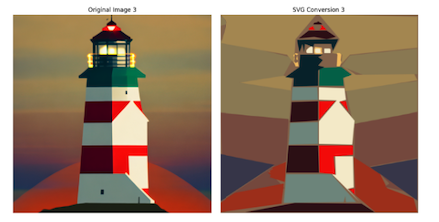

In [1]:
#| default_exp core

In [2]:
#| export

import kagglehub

import os
import io
import re
import random
import base64
from io import BytesIO

import time
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from IPython.display import SVG

from PIL import Image
import cv2

from diffusers import StableDiffusionPipeline
from transformers import AutoProcessor, AutoModel


metric = kagglehub.package_import('jiazhuang/svg-image-fidelity')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Installing python dependencies for Package 'kagglehub_package_jiazhuang_svg_image_fidelity_12', logging progress to '/tmp/kagglehub-package-dependencies-install-cix_9jkk.txt'.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
print(dir(metric))

['AestheticEvaluator', 'AestheticPredictor', 'ImageProcessor', 'ParticipantVisibleError', 'VQAEvaluator', '__all__', '__builtins__', '__cached__', '__dependency_manager_notebook__', '__doc__', '__docker_image__', '__file__', '__gpus__', '__loader__', '__name__', '__package__', '__package_version__', '__path__', '__spec__', 'aesthetic_evaluator', 'core', 'harmonic_mean', 'kagglehub', 'module', 'score', 'score_instance', 'score_instance_impl', 'svg_constraints', 'svg_to_png', 'vqa_evaluator']


In [4]:
# --- CRITICAL DEBUGGING STEP ---
print("Attributes of 'metric':", dir(metric))

# If you see any attributes that look like submodules (e.g., 'core', 'utils', 'main', 'svg_fidelity_utils'),
# then inspect them further:
for attr_name in dir(metric):
    attr = getattr(metric, attr_name)
    if hasattr(attr, '__module__') and not attr_name.startswith('__'): # Check if it's a module
        print(f"\nAttributes of 'metric.{attr_name}':", dir(attr))

# If you want to be exhaustive and search deeper:
# This will search for the string 'ImageProcessor' in the names of all attributes
# and sub-attributes.
found_path = None
for attr_name in dir(metric):
    attr = getattr(metric, attr_name)
    if 'ImageProcessor' in attr_name:
        found_path = f"metric.{attr_name}"
        break
    if hasattr(attr, '__module__') and not attr_name.startswith('__'):
        for sub_attr_name in dir(attr):
            if 'ImageProcessor' in sub_attr_name:
                found_path = f"metric.{attr_name}.{sub_attr_name}"
                break
    if found_path:
        break

if found_path:
    print(f"\nPotential path for ImageProcessor: {found_path}")
else:
    print("\n'ImageProcessor' not found directly in metric or its immediate submodules.")

# --- END CRITICAL DEBUGGING STEP ---


Attributes of 'metric': ['AestheticEvaluator', 'AestheticPredictor', 'ImageProcessor', 'ParticipantVisibleError', 'VQAEvaluator', '__all__', '__builtins__', '__cached__', '__dependency_manager_notebook__', '__doc__', '__docker_image__', '__file__', '__gpus__', '__loader__', '__name__', '__package__', '__package_version__', '__path__', '__spec__', 'aesthetic_evaluator', 'core', 'harmonic_mean', 'kagglehub', 'module', 'score', 'score_instance', 'score_instance_impl', 'svg_constraints', 'svg_to_png', 'vqa_evaluator']

Attributes of 'metric.AestheticEvaluator': ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'load', 'score']

Attributes of 'metric.AestheticPredictor': ['T_destination', '__annotatio

## Competition Metric Helpers

We also want to evaluate metrics of the original bitmap before converting to svg. Let’s implement it using [metric package](https://www.kaggle.com/code/jiazhuang/svg-image-fidelity).

In [5]:
import kagglehub
import numpy as np

metric = kagglehub.package_import('jiazhuang/svg-image-fidelity')

print("Attributes of 'metric.module':", dir(metric.module))

# And let's be thorough, check for 'ImageProcessor' within it again:
found_path_in_module = None
for attr_name in dir(metric.module):
    if 'ImageProcessor' in attr_name:
        found_path_in_module = f"metric.module.{attr_name}"
        break
if found_path_in_module:
    print(f"\nPotential path for ImageProcessor: {found_path_in_module}")
else:
    print("\n'ImageProcessor' not found in metric.module.")

Attributes of 'metric.module': ['AestheticEvaluator', 'AestheticPredictor', 'ImageProcessor', 'ParticipantVisibleError', 'VQAEvaluator', '__all__', '__builtins__', '__cached__', '__dependency_manager_notebook__', '__doc__', '__docker_image__', '__file__', '__gpus__', '__loader__', '__name__', '__package__', '__package_version__', '__path__', '__spec__', 'aesthetic_evaluator', 'core', 'harmonic_mean', 'kagglehub', 'module', 'score', 'score_instance', 'score_instance_impl', 'svg_constraints', 'svg_to_png', 'vqa_evaluator']

Potential path for ImageProcessor: metric.module.ImageProcessor


In [6]:
import numpy as np
import statistics
import pandas as pd

def image_resize(image, size=(384, 384)):
    return image.convert('RGB').resize(size)

def bitmap_score_instance_impl(multiple_choice_qa, image, random_seed=52):
    rng = np.random.RandomState(random_seed)
    group_seed = rng.randint(0, np.iinfo(np.int32).max)
    image_processor = metric.ImageProcessor(image=image_resize(image), seed=group_seed).apply()
    image = image_processor.image.copy()
    questions = multiple_choice_qa['question']
    choices = multiple_choice_qa['choices']
    answers = multiple_choice_qa['answer']
    aesthetic_score = metric.aesthetic_evaluator.score(image)
    vqa_score = metric.vqa_evaluator.score(questions, choices, answers, image)
    image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
    ocr_score = metric.vqa_evaluator.ocr(image_processor.image)
    instance_score = metric.harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
    return instance_score, vqa_score, ocr_score, aesthetic_score

def bitmap_score_instance(multiple_choice_qa, image, random_seed=52):
    is_single = not isinstance(image, list)
    if is_single:
        multiple_choice_qa = [multiple_choice_qa]
        image = [image]
    
    assert len(multiple_choice_qa) == len(image)

    results = []
    score_df = []
    for one_image, one_multiple_choice_qa in zip(image, multiple_choice_qa, strict=True):
        instance_score, vqa_score, ocr_score, aesthetic_score = bitmap_score_instance_impl(one_multiple_choice_qa, one_image, random_seed=52)
        results.append(instance_score)
        score_df.append([instance_score, vqa_score, ocr_score, aesthetic_score])

    fidelity = statistics.mean(results)
    score_df = pd.DataFrame(score_df, columns=['competition_score', 'vqa_score', 'ocr_score', 'aesthetic_score'])
    if is_single:
        return score_df.iloc[0].to_dict()
    else:
        return float(fidelity), score_df

## Load Stable Diffusion

In [7]:
#| export

# Ensure GPU is being used and optimize for speed
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler

# Load with optimized scheduler and half precision
stable_diffusion_path = kagglehub.model_download("stabilityai/stable-diffusion-v2/pytorch/1/1")

scheduler = DDIMScheduler.from_pretrained(stable_diffusion_path, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    stable_diffusion_path,
    scheduler=scheduler,
    torch_dtype=torch.float16,  # Use half precision
    safety_checker=None         # Disable safety checker for speed
)

# Move to GPU and apply optimizations
pipe.to(device) 

Using device: cuda:1


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "/kaggle/input/stable-diffusion-v2/pytorch/1/1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Load Data

In [8]:
import pandas as pd
import json

In [9]:
drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')
train_df = pd.read_csv(f'{drawing_with_llms_path}/train.csv')
train_question_df = pd.read_parquet(f'{drawing_with_llms_path}/questions.parquet')

In [10]:
train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))
train_question_df = train_question_df.reset_index(name='qa')

train_question_df['question'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['question'], ensure_ascii=False))

train_question_df['choices'] = train_question_df.qa.apply(
    lambda qa: json.dumps(
        [x.tolist() for x in qa['choices']], ensure_ascii=False
    )
)

train_question_df['answer'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['answer'], ensure_ascii=False))

train_df = pd.merge(train_df, train_question_df, how='left', on='id')

train_df['multiple_choice_qa'] = train_df.apply(
    lambda r: {
    'question': json.loads(r.question),
    'choices': json.loads(r.choices),
    'answer': json.loads(r.answer)
    },
    axis=1,
)

train_df.head()

<ipython-input-10-ec90037a8340>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))


id                                        description  \
0  02d892                            a purple forest at dusk   
1  0dcd2e              gray wool coat with a faux fur collar   
2  1e9ac1                 a lighthouse overlooking the ocean   
3  2b25db  burgundy corduroy pants with patch pockets and...   
4  4e6a54                           orange corduroy overalls   

                                                  qa  \
0  {'id': ['02d892', '02d892', '02d892', '02d892'...   
1  {'id': ['0dcd2e', '0dcd2e', '0dcd2e', '0dcd2e'...   
2  {'id': ['1e9ac1', '1e9ac1', '1e9ac1', '1e9ac1'...   
3  {'id': ['2b25db', '2b25db', '2b25db', '2b25db'...   
4  {'id': ['4e6a54', '4e6a54', '4e6a54', '4e6a54'...   

                                            question  \
0  ["What is the main setting of the image?", "Is...   
1  ["What color is the coat?", "What part of the ...   
2  ["Is there an ocean visible in the image?", "W...   
3  ["Are the pants yellow?", "Do the pants have p...   
4  ["What material is the item?", "Is a hat depic...   

                                             choices  \
0  [["beach", "desert", "forest", "mountain"], ["...   
1  [["blue", "brown", "gray", "red"], ["collar", ...   
2  [["no", "yes"], ["inside", "next to", "overloo...   
3  [["no", "yes"], ["no", "yes"], ["no", "yes"], ...   
4  [["corduroy", "denim", "leather", "silk"], ["n...   

                                  answer  \
0    ["forest", "yes", "dusk", "purple"]   
1       ["gray", "collar", "no", "wool"]   
2     ["yes", "overlooking", "no", "no"]   
3          ["no", "yes", "yes", "pants"]   
4  ["corduroy", "no", "yes", "overalls"]   

                                  multiple_choice_qa  
0  {'question': ['What is the main setting of the...  
1  {'question': ['What color is the coat?', 'What...  
2  {'question': ['Is there an ocean visible in th...  
3  {'question': ['Are the pants yellow?', 'Do the...  
4  {'question': ['What material is the item?', 'I...

## Bitmap Generation
* Inference steps (more for better quality / slower)
* Guidance scale (how tightly to follow prompts)

In [11]:
#| export

def generate_bitmap(prompt, negative_prompt="", num_inference_steps=20, guidance_scale=15):
        
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps, 
        guidance_scale=guidance_scale,
    ).images[0]
    
    return image

In [12]:
prompt_prefix = "Simple, classic image of"
prompt_suffix = "with flat color blocks, beautiful, minimal details, solid colors only"
negative_prompt = "lines, framing, hatching, background, textures, patterns, details, outlines"

In [13]:
r = train_df.iloc[2]
description = r.description
print(description)

a lighthouse overlooking the ocean


In [14]:
prompt = f'{prompt_prefix} {description} {prompt_suffix}'
print(prompt)

Simple, classic image of a lighthouse overlooking the ocean with flat color blocks, beautiful, minimal details, solid colors only


  0%|          | 0/20 [00:00<?, ?it/s]

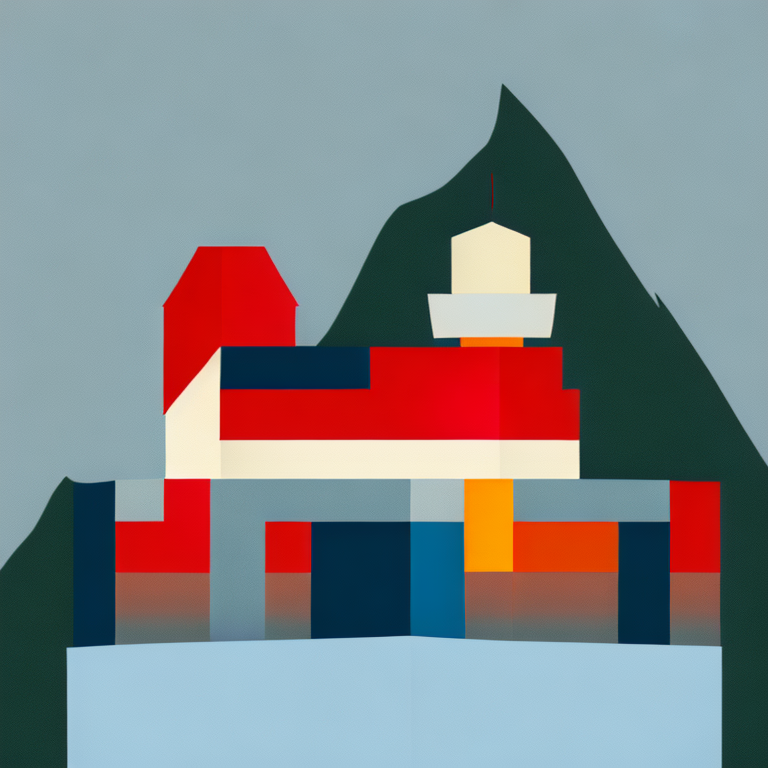

In [15]:
image = generate_bitmap(prompt, negative_prompt=negative_prompt)
image

In [16]:
bitmap_score_instance(r.multiple_choice_qa, image, random_seed=52)

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


{'competition_score': 0.7300827116654716,
 'vqa_score': 0.820747976214891,
 'ocr_score': 1.0,
 'aesthetic_score': 0.506345558166504}

# Image -> SVG

* Did a bunch of work here trying to get good results..

In [17]:
#| export

def compress_hex_color(hex_color):
    """Convert hex color to shortest possible representation"""
    r, g, b = int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)
    if r % 17 == 0 and g % 17 == 0 and b % 17 == 0:
        return f'#{r//17:x}{g//17:x}{b//17:x}'
    return hex_color

def extract_features_by_scale(img_np, num_colors=16):
    """
    Extract image features hierarchically by scale
    
    Args:
        img_np (np.ndarray): Input image
        num_colors (int): Number of colors to quantize
    
    Returns:
        list: Hierarchical features sorted by importance
    """
    # Convert to RGB if needed
    if len(img_np.shape) == 3 and img_np.shape[2] > 1:
        img_rgb = img_np
    else:
        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    # Perform color quantization
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Quantized image
    palette = centers.astype(np.uint8)
    quantized = palette[labels.flatten()].reshape(img_rgb.shape)
    
    # Hierarchical feature extraction
    hierarchical_features = []
    
    # Sort colors by frequency
    unique_labels, counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(-counts)
    sorted_colors = [palette[i] for i in sorted_indices]
    
    # Center point for importance calculations
    center_x, center_y = width/2, height/2
    
    for color in sorted_colors:
        # Create color mask
        color_mask = cv2.inRange(quantized, color, color)
        
        # Find contours
        contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Sort contours by area (largest first)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        
        # Convert RGB to compressed hex
        hex_color = compress_hex_color(f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}')
        
        color_features = []
        for contour in contours:
            # Skip tiny contours
            area = cv2.contourArea(contour)
            if area < 20:
                continue
            
            # Calculate contour center
            m = cv2.moments(contour)
            if m["m00"] == 0:
                continue
            
            cx = int(m["m10"] / m["m00"])
            cy = int(m["m01"] / m["m00"])
            
            # Distance from image center (normalized)
            dist_from_center = np.sqrt(((cx - center_x) / width)**2 + ((cy - center_y) / height)**2)
            
            # Simplify contour
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Generate points string
            points = " ".join([f"{pt[0][0]:.1f},{pt[0][1]:.1f}" for pt in approx])
            
            # Calculate importance (area, proximity to center, complexity)
            importance = (
                area * 
                (1 - dist_from_center) * 
                (1 / (len(approx) + 1))
            )
            
            color_features.append({
                'points': points,
                'color': hex_color,
                'area': area,
                'importance': importance,
                'point_count': len(approx),
                'original_contour': approx  # Store original contour for adaptive simplification
            })
        
        # Sort features by importance within this color
        color_features.sort(key=lambda x: x['importance'], reverse=True)
        hierarchical_features.extend(color_features)
    
    # Final sorting by overall importance
    hierarchical_features.sort(key=lambda x: x['importance'], reverse=True)
    
    return hierarchical_features

def simplify_polygon(points_str, simplification_level):
    """
    Simplify a polygon by reducing coordinate precision or number of points
    
    Args:
        points_str (str): Space-separated "x,y" coordinates
        simplification_level (int): Level of simplification (0-3)
    
    Returns:
        str: Simplified points string
    """
    if simplification_level == 0:
        return points_str
    
    points = points_str.split()
    
    # Level 1: Round to 1 decimal place
    if simplification_level == 1:
        return " ".join([f"{float(p.split(',')[0]):.1f},{float(p.split(',')[1]):.1f}" for p in points])
    
    # Level 2: Round to integer
    if simplification_level == 2:
        return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in points])
    
    # Level 3: Reduce number of points (keep every other point, but ensure at least 3 points)
    if simplification_level == 3:
        if len(points) <= 4:
            # If 4 or fewer points, just round to integer
            return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in points])
        else:
            # Keep approximately half the points, but maintain at least 3
            step = min(2, len(points) // 3)
            reduced_points = [points[i] for i in range(0, len(points), step)]
            # Ensure we keep at least 3 points and the last point
            if len(reduced_points) < 3:
                reduced_points = points[:3]
            if points[-1] not in reduced_points:
                reduced_points.append(points[-1])
            return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in reduced_points])
    
    return points_str

def bitmap_to_svg_layered(image, max_size_bytes=9200, resize=True, target_size=(384, 384), 
                         adaptive_fill=True, num_colors=None):
    """
    Convert bitmap to SVG using layered feature extraction with optimized space usage
    
    Args:
        image: Input image (PIL.Image)
        max_size_bytes (int): Maximum SVG size
        resize (bool): Whether to resize the image before processing
        target_size (tuple): Target size for resizing (width, height)
        adaptive_fill (bool): Whether to adaptively fill available space
        num_colors (int): Number of colors to quantize, if None uses adaptive selection
    
    Returns:
        str: SVG representation
    """
    # Adaptive color selection based on image complexity
    if num_colors is None:
        # Simple heuristic: more colors for complex images
        if resize:
            pixel_count = target_size[0] * target_size[1]
        else:
            pixel_count = image.size[0] * image.size[1]
        
        if pixel_count < 65536:  # 256x256
            num_colors = 8
        elif pixel_count < 262144:  # 512x512
            num_colors = 12
        else:
            num_colors = 16
    
    # Resize the image if requested
    if resize:
        original_size = image.size
        image = image.resize(target_size, Image.LANCZOS)
    else:
        original_size = image.size
    
    # Convert to numpy array
    img_np = np.array(image)
    
    # Get image dimensions
    height, width = img_np.shape[:2]
    
    # Calculate average background color
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        avg_bg_color = np.mean(img_np, axis=(0,1)).astype(int)
        bg_hex_color = compress_hex_color(f'#{avg_bg_color[0]:02x}{avg_bg_color[1]:02x}{avg_bg_color[2]:02x}')
    else:
        bg_hex_color = '#fff'
    
    # Start building SVG
    # Use original dimensions in viewBox for proper scaling when displayed
    orig_width, orig_height = original_size
    svg_header = f'<svg xmlns="http://www.w3.org/2000/svg" width="{orig_width}" height="{orig_height}" viewBox="0 0 {width} {height}">\n'
    svg_bg = f'<rect width="{width}" height="{height}" fill="{bg_hex_color}"/>\n'
    svg_base = svg_header + svg_bg
    svg_footer = '</svg>'
    
    # Calculate base size
    base_size = len((svg_base + svg_footer).encode('utf-8'))
    available_bytes = max_size_bytes - base_size
    
    # Extract hierarchical features
    features = extract_features_by_scale(img_np, num_colors=num_colors)
    
    # If not using adaptive fill, just add features until we hit the limit
    if not adaptive_fill:
        svg = svg_base
        for feature in features:
            # Try adding the feature
            feature_svg = f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n'
            
            # Check if adding this feature exceeds size limit
            if len((svg + feature_svg + svg_footer).encode('utf-8')) > max_size_bytes:
                break
            
            # Add the feature
            svg += feature_svg
        
        # Close SVG
        svg += svg_footer
        return svg
    
    # For adaptive fill, use binary search to find optimal simplification level
    
    # First attempt: calculate size of all features at different simplification levels
    feature_sizes = []
    for feature in features:
        feature_sizes.append({
            'original': len(f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n'.encode('utf-8')),
            'level1': len(f'<polygon points="{simplify_polygon(feature["points"], 1)}" fill="{feature["color"]}" />\n'.encode('utf-8')),
            'level2': len(f'<polygon points="{simplify_polygon(feature["points"], 2)}" fill="{feature["color"]}" />\n'.encode('utf-8')),
            'level3': len(f'<polygon points="{simplify_polygon(feature["points"], 3)}" fill="{feature["color"]}" />\n'.encode('utf-8'))
        })
    
    # Two-pass approach: first add most important features, then fill remaining space
    svg = svg_base
    bytes_used = base_size
    added_features = set()
    
    # Pass 1: Add most important features at original quality
    for i, feature in enumerate(features):
        feature_svg = f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n'
        feature_size = feature_sizes[i]['original']
        
        if bytes_used + feature_size <= max_size_bytes:
            svg += feature_svg
            bytes_used += feature_size
            added_features.add(i)
    
    # Pass 2: Try to add remaining features with progressive simplification
    for level in range(1, 4):  # Try simplification levels 1-3
        for i, feature in enumerate(features):
            if i in added_features:
                continue
                
            feature_size = feature_sizes[i][f'level{level}']
            if bytes_used + feature_size <= max_size_bytes:
                feature_svg = f'<polygon points="{simplify_polygon(feature["points"], level)}" fill="{feature["color"]}" />\n'
                svg += feature_svg
                bytes_used += feature_size
                added_features.add(i)
    
    # Finalize SVG
    svg += svg_footer
    
    # Double check we didn't exceed limit
    final_size = len(svg.encode('utf-8'))
    if final_size > max_size_bytes:
        # If we somehow went over, return basic SVG
        return f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {width} {height}"><rect width="{width}" height="{height}" fill="{bg_hex_color}"/></svg>'
    
    # Calculate space utilization
    utilization = (final_size / max_size_bytes) * 100
    
    # Return the SVG with efficient space utilization
    return svg

In [18]:
from IPython.display import SVG

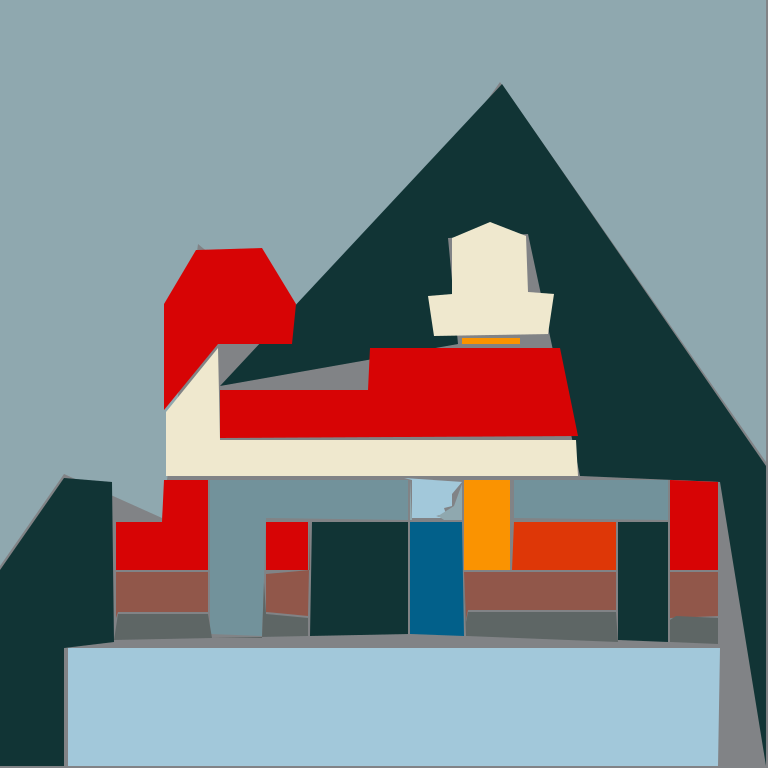

In [19]:
svg_content = bitmap_to_svg_layered(image)
SVG(svg_content)

In [20]:
%%time
metric.score_instance(r.multiple_choice_qa, svg_content, random_seed=52)

CPU times: user 5.45 s, sys: 2.55 s, total: 8.01 s
Wall time: 7.92 s


{'competition_score': 0.6638178328219885,
 'vqa_score': 0.7532335842014414,
 'ocr_score': 1.0,
 'aesthetic_score': 0.45009579658508303}

In [21]:
#| export
def get_aes_and_ocr_score(svg_content):
    image_processor = metric.ImageProcessor(image=metric.svg_to_png(svg_content), seed=52).apply()
    image = image_processor.image.copy()
    aesthetic_score = metric.aesthetic_evaluator.score(image)
    image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
    ocr_score = metric.vqa_evaluator.ocr(image_processor.image)
    return aesthetic_score, ocr_score

In [22]:
ocr_score, aesthetic_score = get_aes_and_ocr_score(svg_content)
ocr_score, aesthetic_score

(0.45535969734191895, 1.0)

# ASE enhanced

In [23]:
#| export

import xml.etree.ElementTree as ET

In [24]:
#| export

def high_score_svg_resize(
    svg_code: str,
    new_size: int = 384,
    padding_ratio: float = 0.1,
    min_stroke: float = 1.5,
    max_stroke: float = 16,
    preserve_aspect: bool = True
) -> str:
    """
    Enhances the SVG code by adjusting the stroke width, font size, and scaling it to the new size.
    
    Parameters:
    svg_code (str): The original SVG code.
    new_size (int): The target size for the SVG (default 384).
    padding_ratio (float): Padding to apply around the SVG (default 0.1).
    min_stroke (float): Minimum stroke width (default 1.5).
    max_stroke (float): Maximum stroke width (default 16).
    preserve_aspect (bool): Whether to preserve the aspect ratio (default True).
    
    Returns:
    str: The enhanced SVG code.
    """
    root = ET.fromstring(svg_code)
    viewBox = root.get("viewBox")
    if viewBox is None:
        viewBox = "0 0 96 96"
        root.set("viewBox", viewBox)
    vb_x, vb_y, vb_w, vb_h = map(float, viewBox.strip().split())

    scale = (1 - 2 * padding_ratio) * new_size / max(vb_w, vb_h)
    translate_x = (new_size - vb_w * scale) / 2
    translate_y = (new_size - vb_h * scale) / 2

    # Transform the SVG content to adjust scaling and positioning
    g = ET.Element("g")
    transform = f"translate({translate_x:.2f},{translate_y:.2f}) scale({scale:.4f}) translate({-vb_x:.6f},{-vb_y:.6f})"
    g.set("transform", transform)

    # Remove structural elements and append to the main group
    structural_tags = {
        ET.QName("http://www.w3.org/2000/svg", ln)
        for ln in ['defs', 'style', 'title', 'metadata', 'script']
    }
    for child in list(root):
        qname = ET.QName(child.tag)
        if qname in structural_tags:
            continue
        g.append(child)
        root.remove(child)
    root.append(g)

    # Update width, height, and viewBox to the new size
    root.set("width", str(new_size))
    root.set("height", str(new_size))
    root.set("viewBox", f"0 0 {new_size} {new_size}")
    if preserve_aspect:
        root.set("preserveAspectRatio", "xMidYMid meet")

    # Adjust stroke-width and font-size to fit the new scale
    def scale_visuals(el, scale_factor):
        for attr in ("stroke-width", "font-size"):
            if attr in el.attrib:
                try:
                    original = float(el.attrib[attr])
                    effective = original * scale_factor
                    clamped = max(min_stroke, min(max_stroke, effective))
                    new_val = clamped / scale_factor
                    el.attrib[attr] = f"{new_val:.2f}"
                except ValueError:
                    pass
        for child in el:
            scale_visuals(child, scale_factor)

    scale_visuals(g, scale)
    return ET.tostring(root, encoding="unicode")

In [25]:
# 检测svg是否合规
svg_constraints_temp = kagglehub.package_import('metric/svg-constraints')
constraints = svg_constraints_temp.SVGConstraints()

## Implement the package Model class

In [26]:
#| export

class Model:
    def __init__(self):
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        # self.prompt_prefix = "Simple, classic image of"
        # self.prompt_suffix = "with flat color blocks, beautiful, minimal details, solid colors only."
        self.prompt_prefix = "Generate a simple, sooth and classic image of"
        self.prompt_suffix = "with flat color blocks, selective detailing on key elements, simplified forms elsewhere, solid color fills, high-contrast outlines on focal points, clean negative space, smooth texture transitions, and balanced visual hierarchy."
        self.negative_prompt = "lines, framing, hatching, background, textures, patterns, details, outlines"

        self.num_inference_steps = 25
        self.guidance_scale = 20
        self.num_attempt = 4

    def gen_bitmap(self, description):
        prompt = f'{self.prompt_prefix} {description} {self.prompt_suffix}'
        bitmap = generate_bitmap(prompt, self.negative_prompt, self.num_inference_steps, self.guidance_scale)
        return bitmap

    def predict_impl(self, prompt: str) -> str:
        best_score = 0.0
        best_svg = None
        best_img = None
        for i in range(self.num_attempt):
            bitmap = self.gen_bitmap(prompt)
            svg = bitmap_to_svg_layered(bitmap)
            svg = high_score_svg_resize(svg) # ASE增强
            
            # try:
            #     # Validate the SVG
            #     constraints.validate_svg(svg)
            #     print("SVG is valid!")
            # except ValueError as e:
            #     print(f"Invalid SVG: {e}")
            
            aesthetic_score, ocr_score = get_aes_and_ocr_score(svg)
            score = aesthetic_score * ocr_score
            if score >= best_score:
                best_score = score
                best_svg = svg
                best_img = bitmap
                print('update score:', best_score)
        
        if best_svg is None:
            best_svg = self.default_svg

        return best_svg, best_img

    def predict(self, prompt: str) -> str:
        svg, img = self.predict_impl(prompt)
        return svg

In [27]:
model = Model()

In [28]:
%%time
svg = model.predict(description)
SVG(svg)

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.46855802536010743


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.5392830848693848


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 58.9 s, sys: 5.41 s, total: 1min 4s
Wall time: 49.8 s


In [29]:
metric.score_instance(r.multiple_choice_qa, svg, random_seed=52)

{'competition_score': 0.8404646998916138,
 'vqa_score': 0.9757369258213204,
 'ocr_score': 1.0,
 'aesthetic_score': 0.5406503677368164}

## Evaluate on train dataset (LB prediction!)

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

In [32]:
train_df.head()

id                                        description  \
0  02d892                            a purple forest at dusk   
1  0dcd2e              gray wool coat with a faux fur collar   
2  1e9ac1                 a lighthouse overlooking the ocean   
3  2b25db  burgundy corduroy pants with patch pockets and...   
4  4e6a54                           orange corduroy overalls   

                                                  qa  \
0  {'id': ['02d892', '02d892', '02d892', '02d892'...   
1  {'id': ['0dcd2e', '0dcd2e', '0dcd2e', '0dcd2e'...   
2  {'id': ['1e9ac1', '1e9ac1', '1e9ac1', '1e9ac1'...   
3  {'id': ['2b25db', '2b25db', '2b25db', '2b25db'...   
4  {'id': ['4e6a54', '4e6a54', '4e6a54', '4e6a54'...   

                                            question  \
0  ["What is the main setting of the image?", "Is...   
1  ["What color is the coat?", "What part of the ...   
2  ["Is there an ocean visible in the image?", "W...   
3  ["Are the pants yellow?", "Do the pants have p...   
4  ["What material is the item?", "Is a hat depic...   

                                             choices  \
0  [["beach", "desert", "forest", "mountain"], ["...   
1  [["blue", "brown", "gray", "red"], ["collar", ...   
2  [["no", "yes"], ["inside", "next to", "overloo...   
3  [["no", "yes"], ["no", "yes"], ["no", "yes"], ...   
4  [["corduroy", "denim", "leather", "silk"], ["n...   

                                  answer  \
0    ["forest", "yes", "dusk", "purple"]   
1       ["gray", "collar", "no", "wool"]   
2     ["yes", "overlooking", "no", "no"]   
3          ["no", "yes", "yes", "pants"]   
4  ["corduroy", "no", "yes", "overalls"]   

                                  multiple_choice_qa  
0  {'question': ['What is the main setting of the...  
1  {'question': ['What color is the coat?', 'What...  
2  {'question': ['Is there an ocean visible in th...  
3  {'question': ['Are the pants yellow?', 'Do the...  
4  {'question': ['What material is the item?', 'I...

In [33]:
%%time
train_df['raw_res'] = train_df.description.progress_apply(model.predict_impl)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.5194339752197266


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.43848552703857424


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.46977953910827636


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.4770987033843994


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.4441674709320068


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.48261346817016604


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.40706577301025393


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.4253397464752197


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.42809114456176756


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.5025205612182617


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 2.394066922283242e-06


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.4415919303894043


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.4525726795196533


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.48341217041015627


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.5582541465759278


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.16098525117851292


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.5313132286071778


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.47873587608337403


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.5632174491882325


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.579752779006958


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.44794306755065916


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.45728344917297364


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.5985596179962158


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.44360876083374023


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.44738407135009767


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.4700597286224365


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 2.775291914405307e-06


  0%|          | 0/25 [00:00<?, ?it/s]

update score: 0.4776057243347168


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 20min 7s, sys: 1min 58s, total: 22min 5s
Wall time: 15min 10s


In [34]:
train_df['svg'] = train_df.raw_res.apply(lambda x: x[0])
train_df['bitmap'] = train_df.raw_res.apply(lambda x: x[1])

In [35]:
train_df['bitmap_score'] = train_df.progress_apply(
    lambda r: bitmap_score_instance(r.multiple_choice_qa, r.bitmap, random_seed=52),
    axis=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

In [36]:
train_df['svg_score'] = train_df.progress_apply(
    lambda r: metric.score_instance(r.multiple_choice_qa, r.svg, random_seed=52),
    axis=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

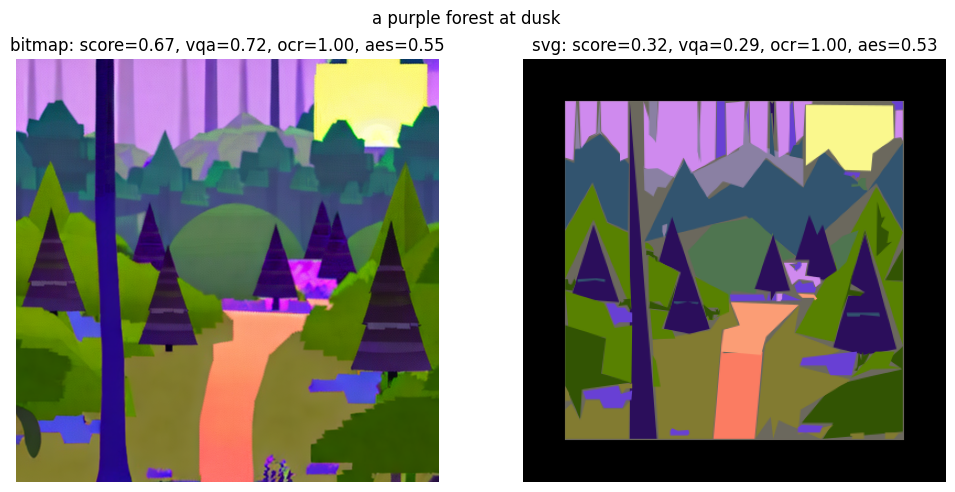

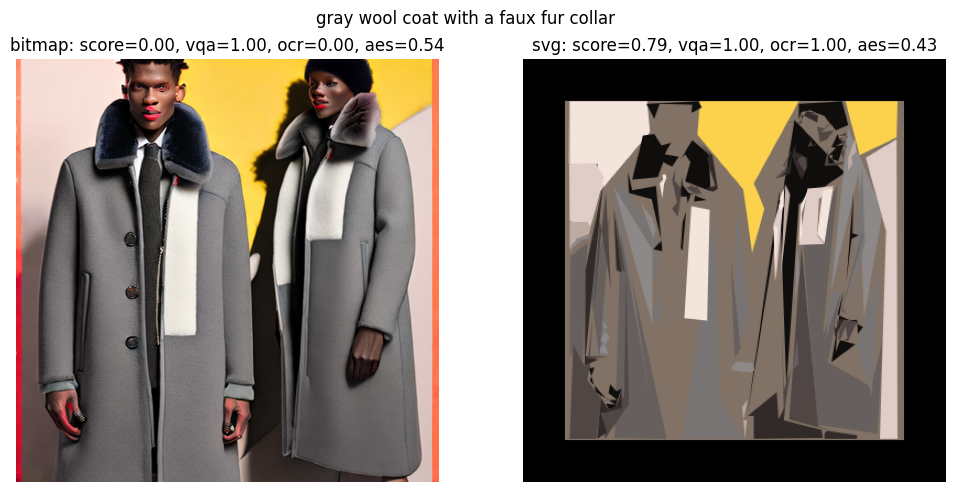

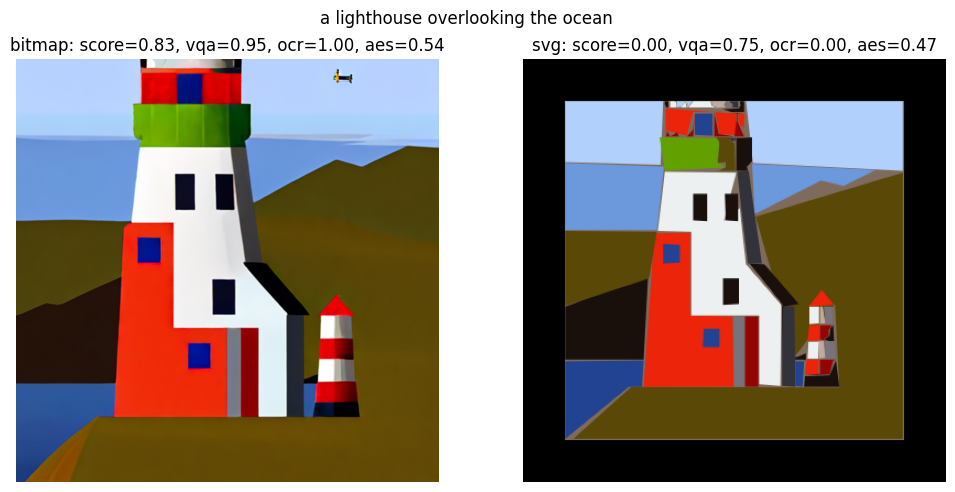

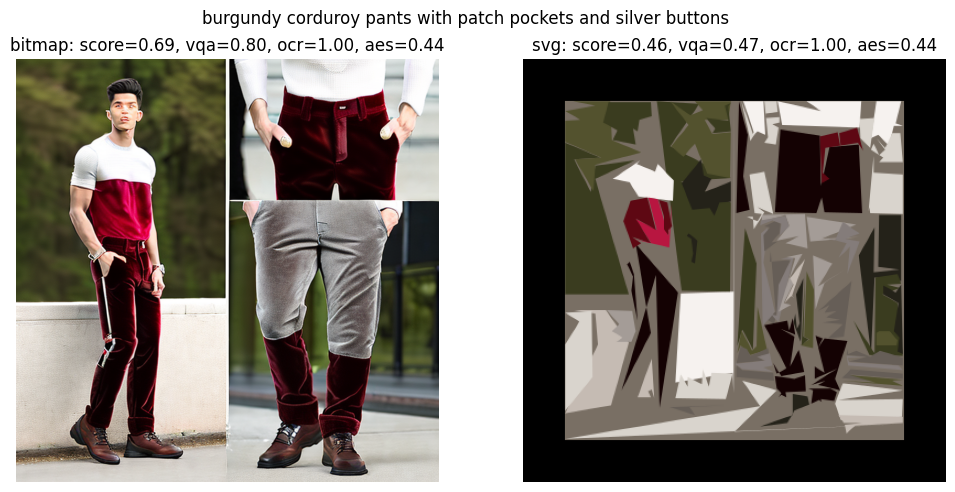

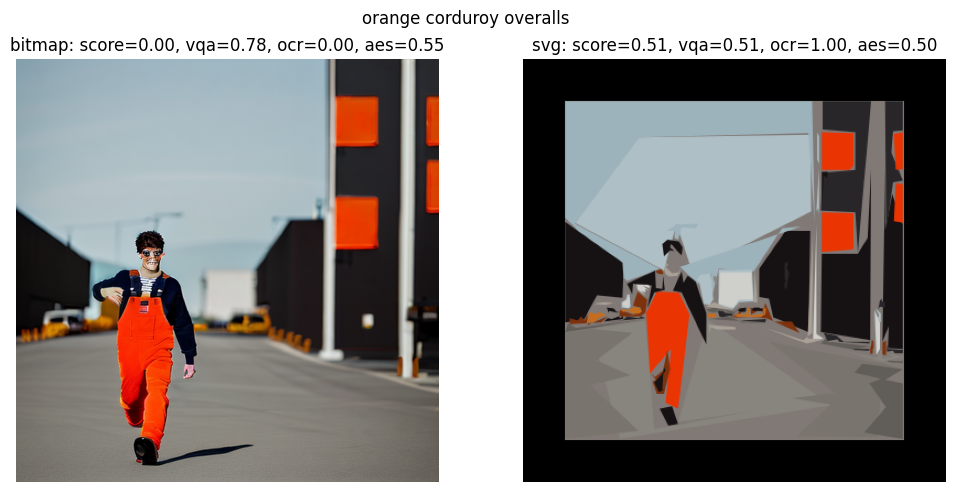

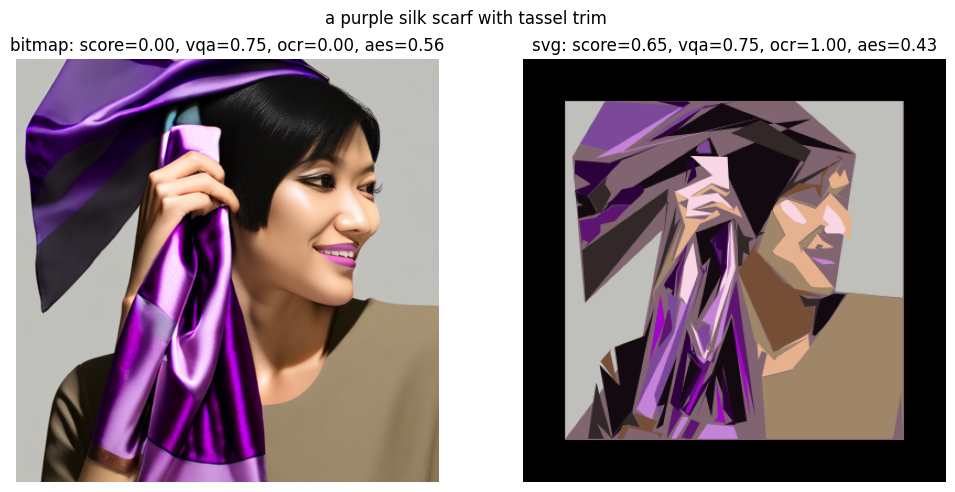

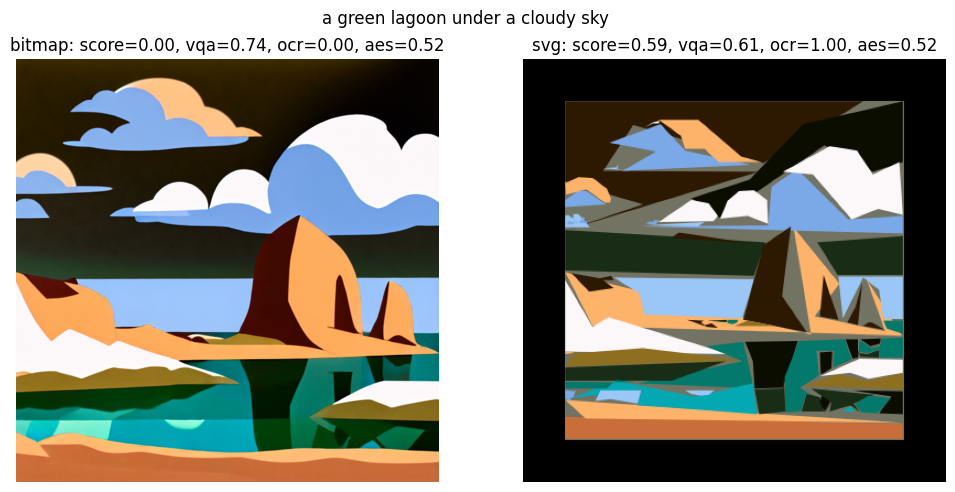

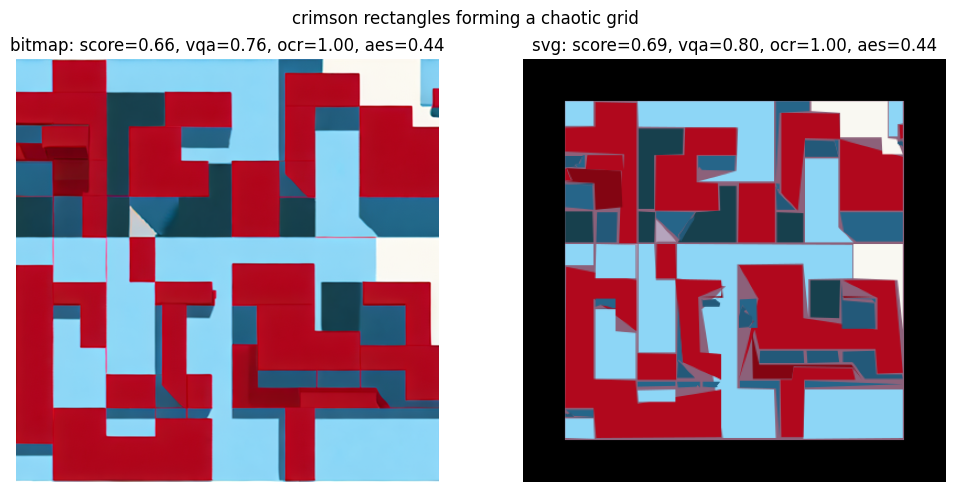

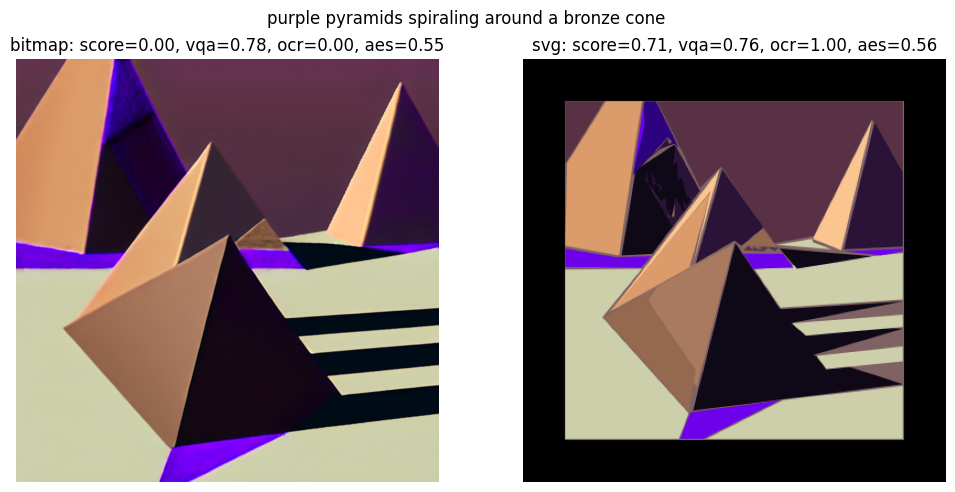

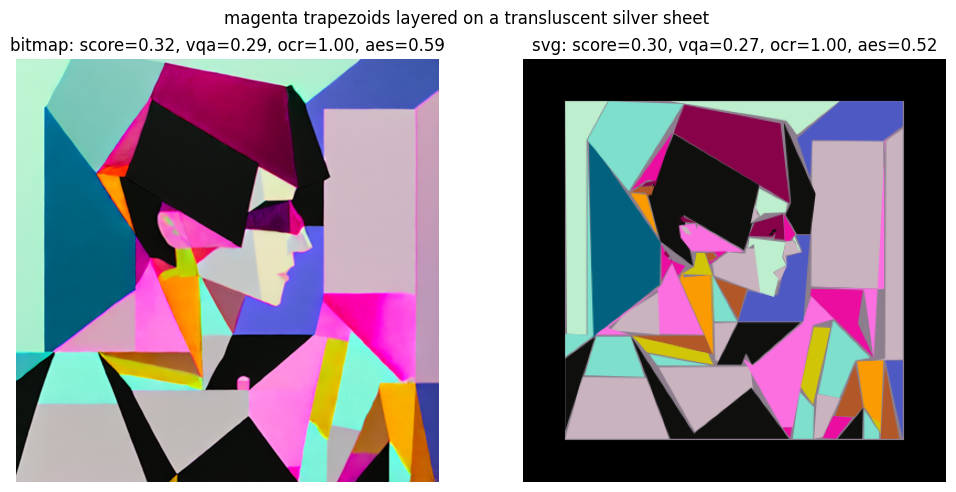

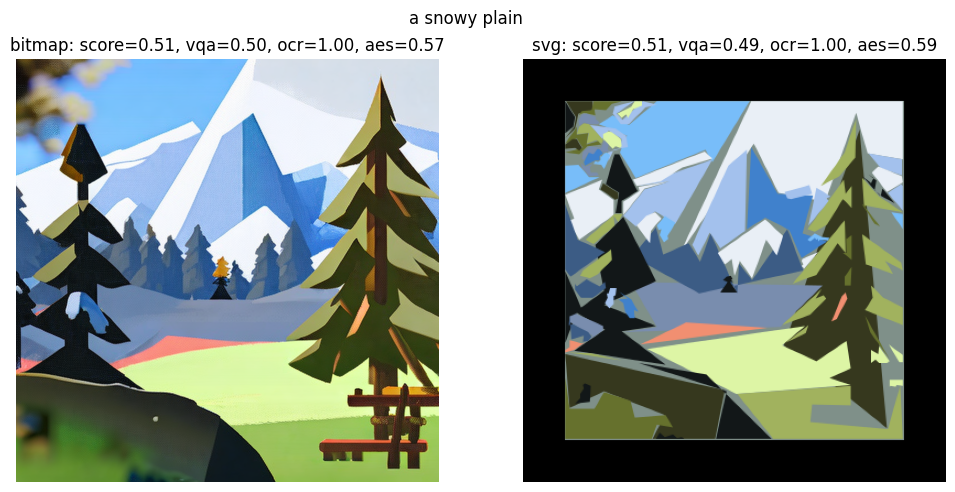

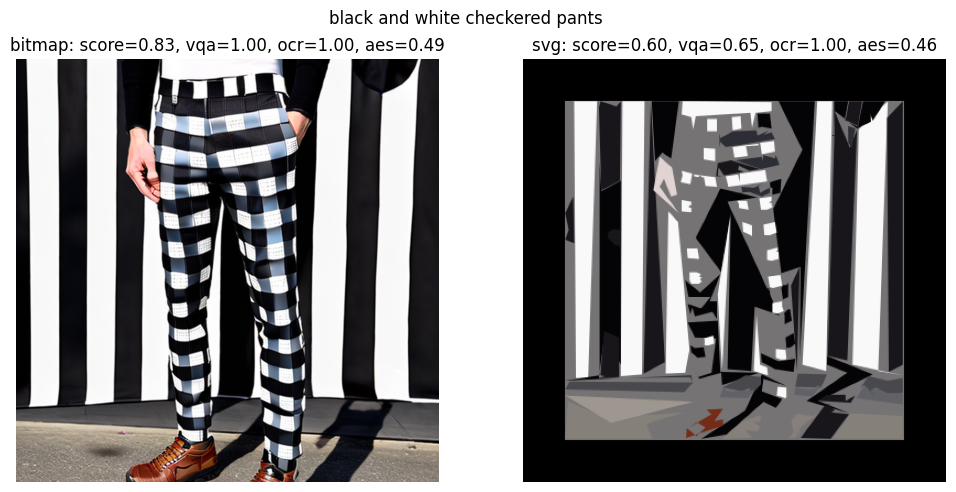

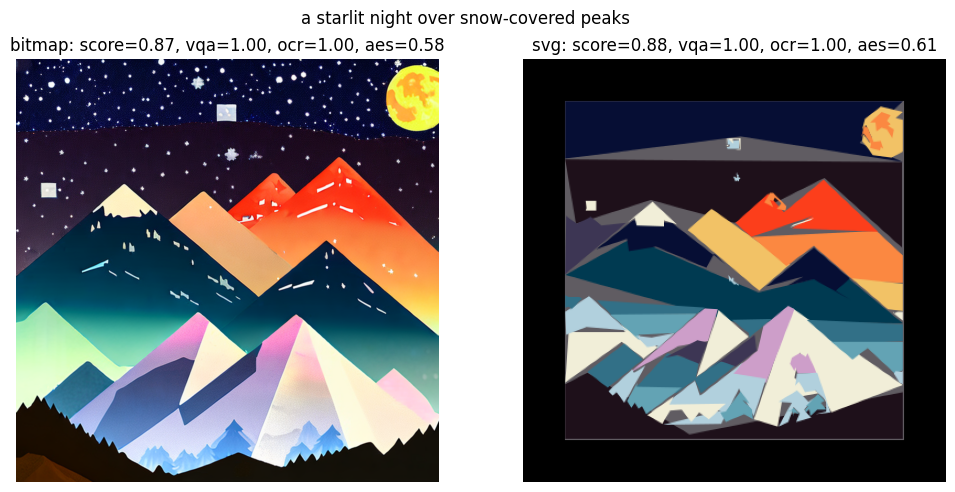

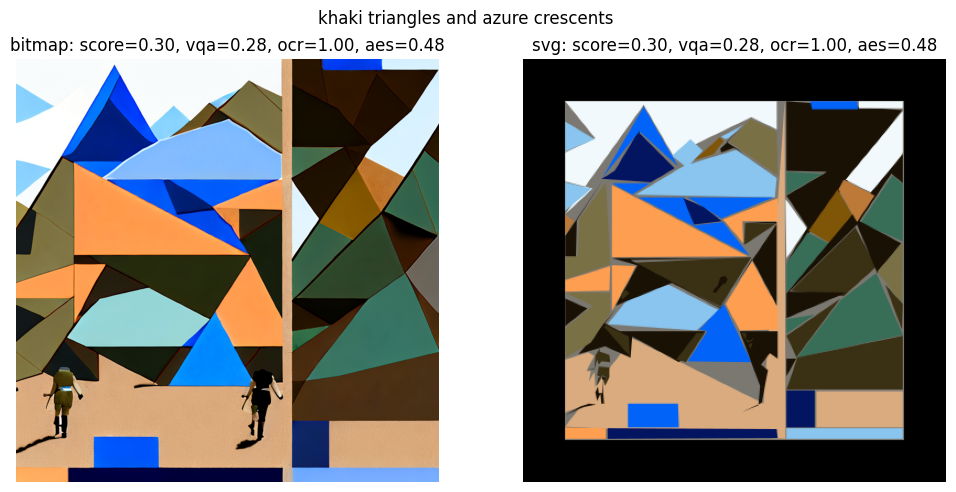

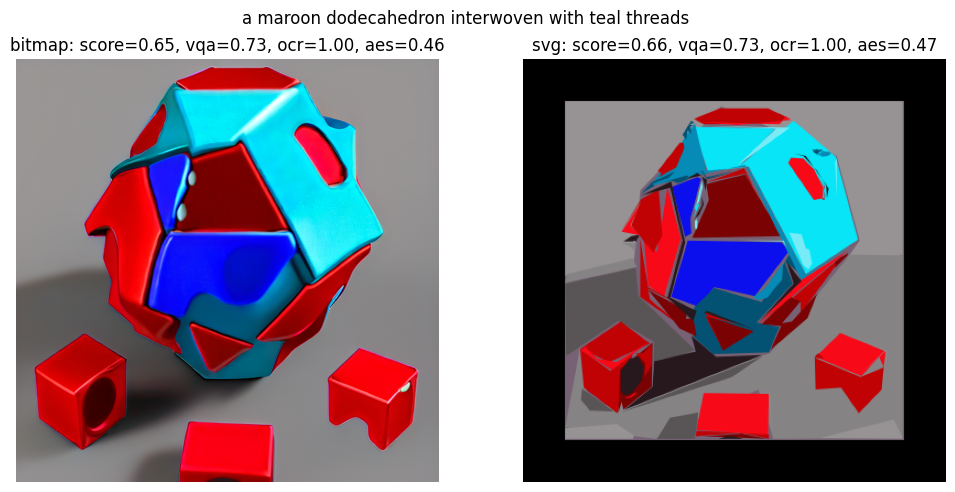

In [37]:
for r in train_df.itertuples():
    b_score = r.bitmap_score['competition_score']
    b_vqa = r.bitmap_score['vqa_score']
    b_ocr = r.bitmap_score['ocr_score']
    b_aesthetic = r.bitmap_score['aesthetic_score']

    s_score = r.svg_score['competition_score']
    s_vqa = r.svg_score['vqa_score']
    s_ocr = r.svg_score['ocr_score']
    s_aesthetic = r.svg_score['aesthetic_score']
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(r.description, y=0.93)
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(r.bitmap))
    plt.axis('off')
    plt.title(f'bitmap: score={b_score:.2f}, vqa={b_vqa:.2f}, ocr={b_ocr:.2f}, aes={b_aesthetic:.2f}')

    plt.subplot(1, 2, 2)
    plt.imshow(metric.svg_to_png(r.svg))
    plt.axis('off')
    plt.title(f'svg: score={s_score:.2f}, vqa={s_vqa:.2f}, ocr={s_ocr:.2f}, aes={s_aesthetic:.2f}')

In [38]:
mean_bitmap_score = pd.DataFrame(train_df['bitmap_score'].tolist()).mean(axis=0)
mean_bitmap_score

competition_score    0.422670
vqa_score            0.737363
ocr_score            0.666720
aesthetic_score      0.524066
dtype: float64

In [39]:
mean_svg_score = pd.DataFrame(train_df['svg_score'].tolist()).mean(axis=0)
mean_svg_score

competition_score    0.531823
vqa_score            0.624049
ocr_score            0.933499
aesthetic_score      0.496302
dtype: float64

In [40]:
print(f'Original bitmap score: {mean_bitmap_score.competition_score}')
print(f'Final svg score: {mean_svg_score.competition_score}')

Original bitmap score: 0.4226700026619929
Final svg score: 0.5318228772347481
